In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [17]:
def load_allele_frequencies(use_data):
    '''
    Loads allele frequency data as seen from STRidER (https://strider.online/frequencies)
    '''
    allele_freq_dict = {} # data to be returned
    if use_data == 'strider':
        # Reading the data inside the xml file to a variable under the name data
        with open('STRidER_frequencies_2019-08-02.xml', 'r') as f:
            data = f.read()

        # Passing the stored data inside the beautifulsoup parser, storing the returned object 
        bs_data = BeautifulSoup(data, "xml")

        # turn xml into dict for use
        marker_data = bs_data.find_all('marker')
        # print(len(marker_data)) # number of markers 
        for md in marker_data:
            loc_name = md.find('name').text # get loci name
            allele_freq_dict[loc_name] = {}
            
            alleles_list = md.find('alleles').text.split(', ') # list of alleles at this site
            origins = md.find_all('origin') # frequency data for different regions/subpopulations
            for orig in origins:
                orig_name = orig.get('name') # name of region
                frequency_dict = {}
                allele_freqs = orig.find_all('frequency') # get allele frequencies for this region
                # add frequency data to dict for all that appear in this specific region
                for allele in allele_freqs:
                    al = allele.get('allele')
                    freq = float(allele.text)
                    frequency_dict[al] = float(allele.text)

                # fill in missing alleles with frequency 0
                for al in alleles_list:
                    frequency_dict[al] = frequency_dict.get(al, 0)
                    
                al_list = list(frequency_dict.keys()) # get allele names in list
                freq_list = list(frequency_dict.values()) # get allele frequencies in list
                # print(sum(freq_list)) # for verifying sum to approx 1
            
                allele_freq_dict[loc_name][orig_name] = {'alleles': al_list} # add info to returned dict
                allele_freq_dict[loc_name][orig_name] = {'frequency': freq_list} # add info to returned dict
    elif use_data == 'nist':
        # read data in
        afam_data = pd.read_csv(os.path.join('NIST', 'NIST Fusion AfAm_Amended2017[1].csv'))
        asian_data = pd.read_csv(os.path.join('NIST', 'NIST Fusion Asian_Amended2017[1].csv'))
        cauc_data = pd.read_csv(os.path.join('NIST', 'NIST Fusion Cauc_Amended2017[1].csv'))
        hisp_data = pd.read_csv(os.path.join('NIST', 'NIST Fusion Hisp_Amended2017[1].csv'))
        data = {'AfAm': afam_data, 'Asian': asian_data, 'Cauc': cauc_data, 'Hisp': hisp_data}
        N = []
        for df in data.values():
            df_n = df[df['Allele'] == 'N']
            N.append(int(df_n.values[0][1]))

            # drop allele from index
            df.drop(df_n.index[0], axis=0, inplace=True)

        # convert data to dictionaries in expected format, also combine to create a total population frequency
        i = 0
        total_allele_counts = {}
        for subpop, df in data.items():
            for col in df.drop('Allele', axis=1).columns:
                key = col.replace('_', ' ') # standardize key values (contributor profiles use space, database uses _)
                # column is the location name ex. D3S1358
                allele_freq_dict[key] = {**allele_freq_dict.get(key, {}), **{subpop: {'alleles': df['Allele'].astype('float'), 'frequency': df[col].astype('float')}}}

                # update total counts of each allele
                n = N[i]
                for j, allele in enumerate(df['Allele']):
                    # iterate over Series
                    allele_freq = df.iloc[j][col] # allele frequency at current location
                    allele_count = allele_freq * n
                    temp_dict = total_allele_counts.get(key, {}) # get allele counts associated w/ location
                    temp_dict[allele] = temp_dict.get(allele, 0) + allele_count  # update counts
                    total_allele_counts[key] = temp_dict # replace counts
            i += 1

        # add total population allele frequencies to data
        for loc, counts in total_allele_counts.items():
            for k, v in counts.items():
                total_allele_counts[loc][k] = v / sum(N) # normalize counts by total number of profiles
            allele_freq_dict[loc]['total'] = {'alleles': [float(k) for k in list(counts.keys())], 
                                              'frequency': [float(f) for f in list(counts.values())]}

    return allele_freq_dict

def load_known_sample(known_sample_path):
    '''
    Reads in known sample from file and puts information into a python dict with following format
    {[site_name]: [allele1, allele2], ... }
    '''
    file_format = known_sample_path.split('.')[-1]
    if file_format == 'txt':
        # assume text file is formatted as necessary python dict
        with open(known_sample_path, 'r') as f:
            known_sample = eval(f.read())
    elif file_format == 'csv':
        data = pd.read_csv(known_sample_path)

        # account for vertical format
        if data.shape[1] < 3:
            data.columns = data.iloc[0].values # assume there is some identifier and actual column names in first row
            data = data.drop(0).reset_index(drop=True).transpose() # convert to horizontal orientation
            data.columns = data.iloc[0].values # first row is the allele location
            data.drop(data.index[0], inplace=True) # get rid of first location

        data = data.iloc[0] # assume first row is desired known profile

        known_sample = {}
        for col in ['CaseNumber', 'Sample']:
            if col in data.index:
                data.drop(col, inplace=True)
        for loc in data.index:
            allele = data[loc]
            key = loc.split('.')[0].replace('_', ' ') # standardize key values (contributor profiles use space, database uses _)
            known_sample[key] = known_sample.get(key, []) + [allele]
    else:
        raise NotImplementedError('File type: .{} not yet supported'.format(file_format))

    return known_sample

def run_simulation(known_sample_path, allele_freq_data, subpop, num_siblings, dest_path):
    # generate samples
    known_sample = load_known_sample(known_sample_path)
    sibling_samples = generate_sibling_samples(known_sample, allele_freq_data, subpop, num_siblings)

    # write output to file
    output = {}
    col_rename = {}
    for i, sample in enumerate([known_sample] + sibling_samples): # output first row is known sample
        for k, v in sample.items():
            output[k] = output.get(k, []) + [float(v[0])] # bit hacky that some are single item lists
            output[k + '.1'] = output.get(k + '.1', []) + [float(v[1])] # bit hacky that some are single item lists
            if i == 0:
                col_rename[k + '.1'] = k # for renaming columns from key.1 to key to preserve same format as input
    output = pd.DataFrame(output)
    output = output.rename(col_rename, axis=1)
    output.to_csv(dest_path)

In [18]:
load_allele_frequencies('nist')

{'D3S1358': {'AfAm': {'alleles': 0      2.2
   1      3.2
   2      4.0
   3      4.2
   4      5.0
         ... 
   92    36.0
   93    37.0
   94    38.0
   95    39.0
   96    43.2
   Name: Allele, Length: 97, dtype: float64,
   'frequency': 0     0.0
   1     0.0
   2     0.0
   3     0.0
   4     0.0
        ... 
   92    0.0
   93    0.0
   94    0.0
   95    0.0
   96    0.0
   Name: D3S1358, Length: 97, dtype: float64},
  'Asian': {'alleles': 0      2.2
   1      3.2
   2      4.0
   3      4.2
   4      5.0
         ... 
   92    36.0
   93    37.0
   94    38.0
   95    39.0
   96    43.2
   Name: Allele, Length: 97, dtype: float64,
   'frequency': 0     0.0
   1     0.0
   2     0.0
   3     0.0
   4     0.0
        ... 
   92    0.0
   93    0.0
   94    0.0
   95    0.0
   96    0.0
   Name: D3S1358, Length: 97, dtype: float64},
  'Cauc': {'alleles': 0      2.2
   1      3.2
   2      4.0
   3      4.2
   4      5.0
         ... 
   92    36.0
   93    37.0
   94    38.0
 

In [4]:
def generate_one_sample(known_sample, allele_freq, subpop):
    rand_sample = {}
    n_replaced = 0 # for validationg distribution of allele overlap b/w siblings
    for loci, allele in known_sample.items():
        # at each loci, choose to either replae 0, 1, or 2 alleles
        a1, a2 = allele
        test = np.random.random()
        if test < 0.25:
            # replace none
            new_alleles = [a1, a2]
        elif test < 0.75:
            n_replaced += 1 # replace one
            p = allele_freq[loci][subpop]['frequency']
            p = p / np.sum(p) # softmax b/c frequencies don't always add to exactly 1
            a3 = np.random.choice(a=allele_freq[loci][subpop]['alleles'], size=1, p=p)
            if np.random.random() < 0.5:
                # replace 1st
                new_alleles = [a3, a2]
            else:
                # replace 2nd
                new_alleles = [a1, a3]
        else:
            n_replaced += 2 # replace both
            p = allele_freq[loci][subpop]['frequency']
            p = p / np.sum(p) # softmax b/c frequencies don't always add to exactly 1
            a3, a4 = np.random.choice(a=allele_freq[loci][subpop]['alleles'], size=2, p=p)
            new_alleles = [a3, a4]
        rand_sample[loci] = new_alleles

    return rand_sample, n_replaced

# def generate_one_sample(known_sample, allele_freq, subpop):
#     '''
#     Generates single possible sibling sample given known sample
#     '''
#     m = len(known_sample) # number of locations 
#     rand_sample = {}
#     n_replaced = 0 # for validationg distribution of allele overlap b/w siblings
    
#     locations = list(known_sample.keys())
#     prop_replace = 0.7 # np.random.normal(0.5, 0.04)
#     replace_mom_locations_idx, replace_dad_locations_idx = np.random.randint( 0, m, (2, int(prop_replace*m)) ) 
#     # In above line, 0.7 gives proper distribution of 38-62% shared b/w siblings but unsure why
#     replace_mom_locations = [locations[idx] for idx in replace_mom_locations_idx]
#     replace_dad_locations = [locations[idx] for idx in replace_dad_locations_idx]
    
#     for loci, allele in known_sample.items():
#         # a1, a2 = allele
#         new_alleles = allele.copy()
#         p = allele_freq[loci][subpop]['frequency']
#         p = p / np.sum(p) # softmax b/c frequencies don't always add to exactly 1
#         if loci in replace_mom_locations:
#             a3 = np.random.choice(a=allele_freq[loci][subpop]['alleles'], size=1, p=p)
#             new_alleles[0] = a3 # assume first allele comes from mom
#             n_replaced += 1
#         if loci in replace_dad_locations:
#             a3 = np.random.choice(a=allele_freq[loci][subpop]['alleles'], size=1, p=p)
#             new_alleles[1] = a3 # assume second allele comes from dad
#             n_replaced += 1
#         rand_sample[loci] = new_alleles
    
#     return rand_sample, n_replaced

def generate_sibling_samples(known_sample, use_freq, subpop, num_siblings):
    '''
    Generates possible sibling DNA profiles given known sample and user-given specifications
    '''
    allele_freq = load_allele_frequencies(use_freq)
    
    N = num_siblings # number of simulated siblings
    simulated_samples = []
    alleles_replaced = [] # for validationg distribution of allele overlap b/w siblings
    for i in range(N):
        rand_sample, n_replaced = generate_one_sample(known_sample, allele_freq, subpop)
        simulated_samples.append(rand_sample)
        alleles_replaced.append(n_replaced)

    return simulated_samples, alleles_replaced

In [11]:
known_sample_path = '17f.csv'
use_freq = 'nist'
subpop = 'Cauc'
num_siblings = 1000

In [12]:
known_sample = load_known_sample(known_sample_path)
sample, alleles_replaced = generate_sibling_samples(known_sample, use_freq, subpop, num_siblings)

7.09090909090909 19.5 13.004136363636364


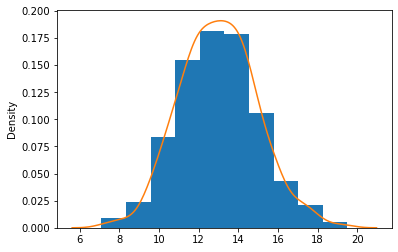

In [7]:
prop_overlap = [(1 - n / len(known_sample) / 2) * 26 for n in alleles_replaced] # 1 minus b/c n is number of alleles replaced
                                                                         # divide by 2 again b/c 2 alleles at each location
print(np.min(prop_overlap), np.max(prop_overlap), np.mean(prop_overlap))
plt.hist(prop_overlap, density=True)
sns.kdeplot(prop_overlap)
plt.show()

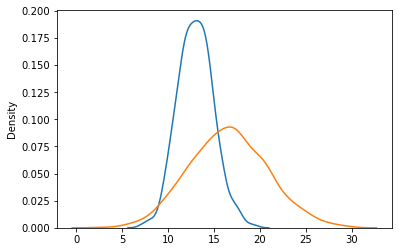

In [9]:
# compare with approximate target normal density
sns.kdeplot(prop_overlap)
sns.kdeplot(np.random.normal(16.5, 4, 1000))
plt.show()